
 __Final Project__
--------------
---------------------------------------------------------------
---------------------------------------------------------------

___1. Basic documant scanner___
----

In [89]:
import cv2
cv2.__version__
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

Load and display the ticket image

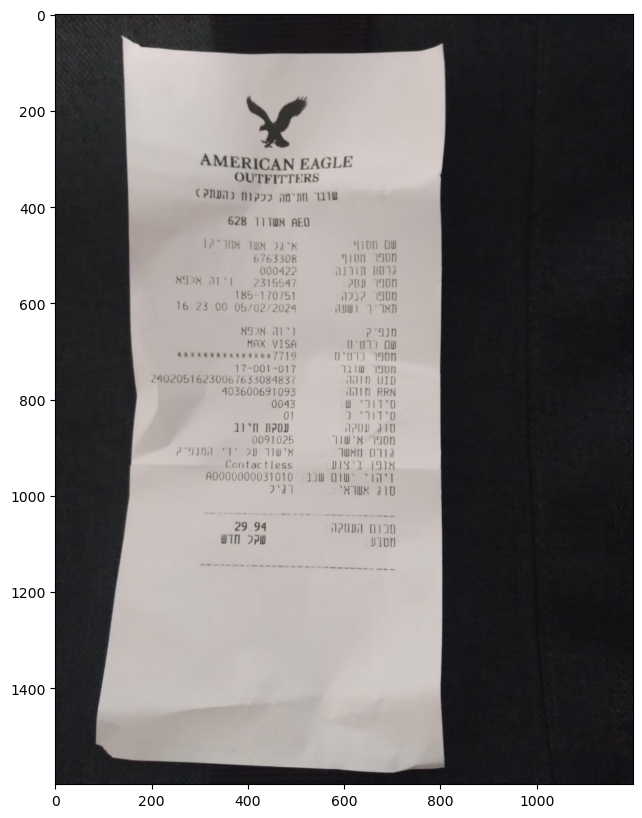

In [90]:
img = plt.imread('ticket.jpg')
plt.subplots(figsize=(15, 10))
plt.imshow(img)
plt.show()

___Edge detecting by gradiants___


 find the image grdiants:
 
 
X-axis gradients, Y-axis gradients and gradient intensity we use for edge detecting

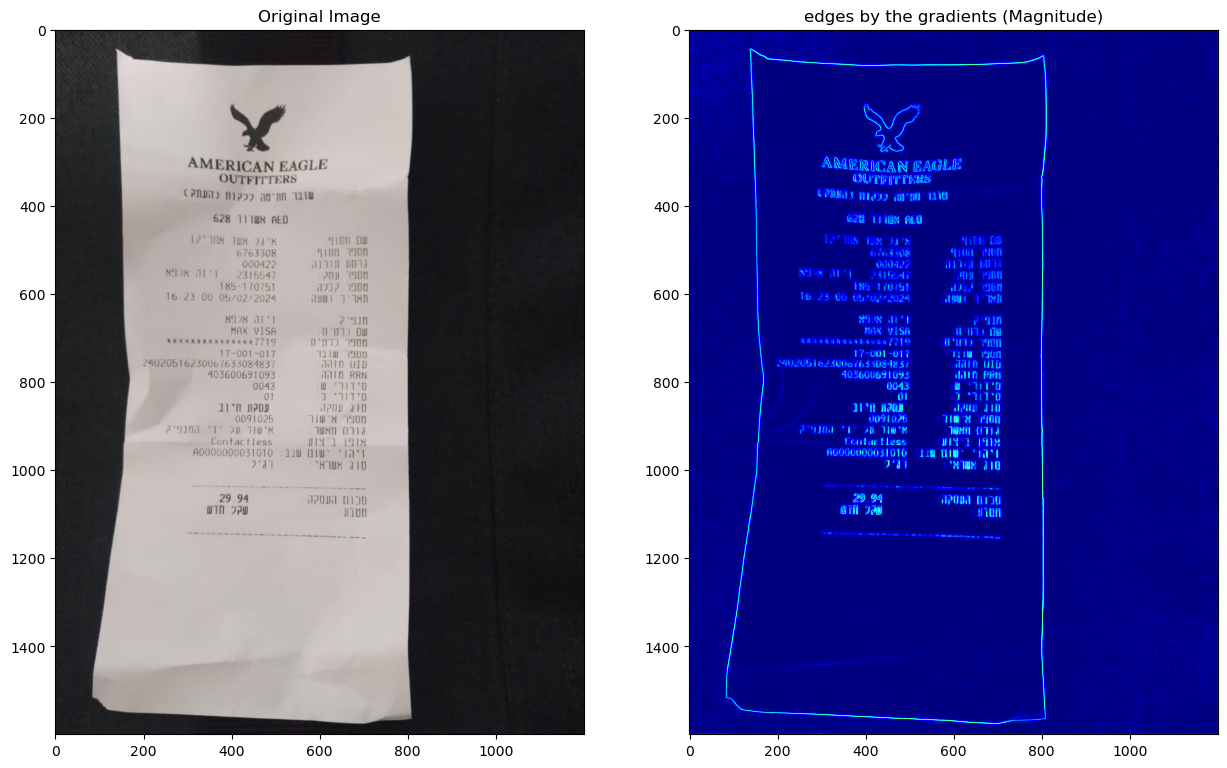

In [91]:
def gradient_simple(img):
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    grad_x = np.diff(img_gray, axis=1, append=0)
    grad_y = np.diff(img_gray, axis=0, append=0)
    grad = np.sqrt(grad_x**2 + grad_y**2)
    return grad

def show_gradients(img, grad):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 15))
    ax[0].imshow(img)
    ax[0].set_title('Original Image')
    ax[1].imshow(grad, cmap='jet')
    ax[1].set_title('edges by the gradients (Magnitude)')
    plt.show()

grad = gradient_simple(img)
show_gradients(img, grad)

___Canny edge detector___


using Canny detecotr function in cv2 to find the edges of the image.

Text(0.5, 1.0, 'Edges detected by Canny Filter')

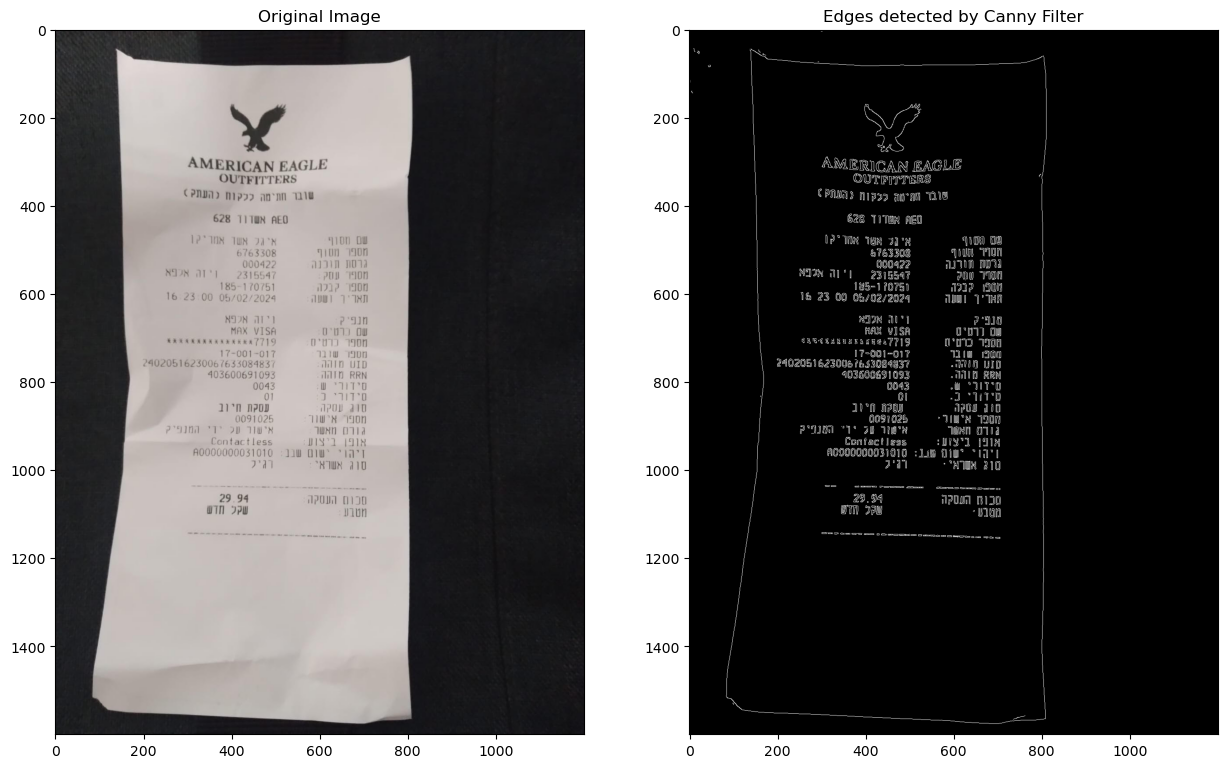

In [92]:
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_edges = cv2.Canny(img_gray, 50, 100)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))
ax[0].imshow(img, cmap='gray')
ax[0].set_title('Original Image')
ax[1].imshow(img_edges, cmap='gray')
ax[1].set_title('Edges detected by Canny Filter')

___Hough Transform___


using Hough transform implemented function to find lines in the image.


input: img_edge - the result of Canny edge detector.
    
    
The idea: finding all the lines that intersect each point of the edges we found and presents all the points where there is a maximum number     of intersecting lines.

In [93]:
from skimage.transform import hough_line, hough_line_peaks

h, theta, d = hough_line(img_edges, theta=np.linspace(-np.pi/2, np.pi/2, 360))
v, angle, dist = hough_line_peaks(h, theta, d)

Display all lines found by the Hough Transform function.


Of these, we will divide all the lines into four groups representing the 4 edges of the document, with an average considered for each group, and we will present four final lines that will delimit the borders of the document.

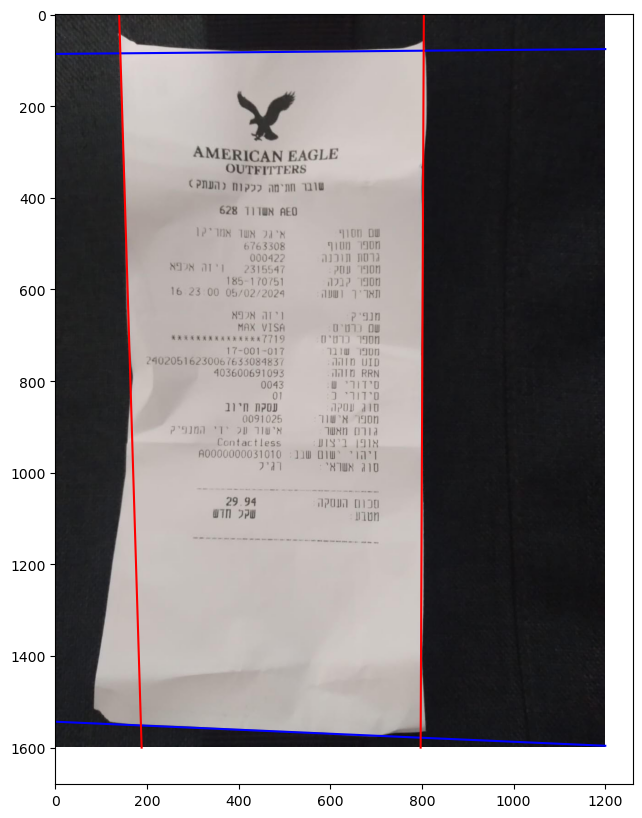

In [94]:

def inside(img, y):
    if y<=0 or y>=img.shape[0]:
        return False
    return True

plt.figure(figsize=(10, 10))
plt.imshow(img, cmap=cm.gray)
origin = np.array((0, img.shape[1]))
originy = np.array((0, img.shape[0]))
list_y1_first = []
list_y0_first = []
list_y1_second = []
list_y0_second = []
list_x1_first = []
list_x0_first = []
list_x1_second = []
list_x0_second = []
for v, angle, dist in zip(*hough_line_peaks(h, theta, d)):
    y0, y1 = (dist - origin * np.cos(angle)) / np.sin(angle)
    x0, x1 = (dist - originy * np.sin(angle)) / np.cos(angle)
    #print(f'General angles {(v,np.rad2deg(angle),dist)}')
    if inside(img ,y0) and inside(img ,y1):
        if y0<200:
            list_y0_first.append(y0)
            list_y1_first.append(y1)
        if y0>1400:
            list_y0_second.append(y0)
            list_y1_second.append(y1)
    else:
        if x0<200:
            list_x0_first.append(x0)
            list_x1_first.append(x1)
        if x0>750:
            list_x0_second.append(x0)
            list_x1_second.append(x1)

# calculate avg for lines
def comp_lines(list):
    count = 0
    for i in list:
        count += i
    return count / len(list)

x0_first_line = comp_lines(list_x0_first)
x1_first_line = comp_lines(list_x1_first)
x0_second_line = comp_lines(list_x0_second)
x1_second_line = comp_lines(list_x1_second)
y0_first_line = comp_lines(list_y0_first)
y1_first_line = comp_lines(list_y1_first)
y0_second_line = comp_lines(list_y0_second)
y1_second_line = comp_lines(list_y1_second)

plt.plot(origin, (comp_lines(list_y0_first), comp_lines(list_y1_first)), '-b')
plt.plot(origin, (comp_lines(list_y0_second), comp_lines(list_y1_second)), '-b')
plt.plot((comp_lines(list_x0_first), comp_lines(list_x1_first)), originy, '-r')
plt.plot((comp_lines(list_x0_second), comp_lines(list_x1_second)), originy, '-r')

___Corners___


In [95]:
from scipy import signal as sig
from skimage import data, io, color
from skimage.feature import corner_harris, corner_peaks

using Harris corner detectors to find corners of the document.


calculate the Ixx, Iyy, Ixy for metrix in the algorithem according to gradients.

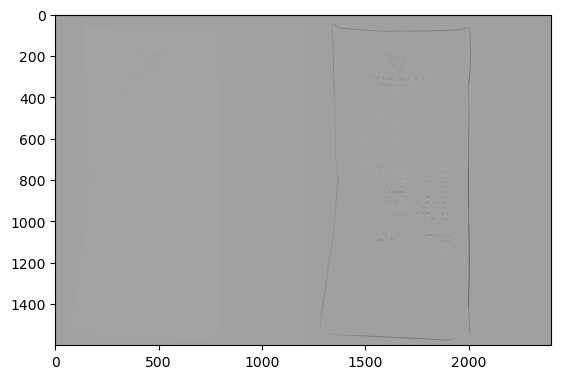

In [96]:
img=color.rgb2gray(img)
def gradient_x(img):
    ##Sobel operator kernels.
    kernel_x = np.array([[-1, 0, 1],[-2, 0, 2],[-1, 0, 1]])
    return sig.convolve2d(img, kernel_x, mode='same')
def gradient_y(img):
    kernel_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
    return sig.convolve2d(img, kernel_y, mode='same')

I_x = gradient_x(img)
I_y = gradient_y(img)

def calculate_harris_response(img, offset = 1, k = 0.05):
  height, width = img.shape
  Ix = gradient_x(img)
  Iy = gradient_y(img)
  Ixx = Ix**2
  Ixy = Ix*Iy
  Iyy = Iy**2

  Sxx = np.zeros((height, width))
  Sxy = np.zeros((height, width))
  Syy = np.zeros((height, width))

  for y in range(offset, height-offset):
      for x in range(offset, width-offset):
          Sxx[y, x] = np.sum(Ixx[y-offset:y+1+offset, x-offset:x+1+offset])
          Syy[y, x] = np.sum(Iyy[y-offset:y+1+offset, x-offset:x+1+offset])
          Sxy[y, x] = np.sum(Ixy[y-offset:y+1+offset, x-offset:x+1+offset])

  det = (Sxx * Syy) - (Sxy**2)
  trace = Sxx + Syy
  return det - k*(trace**2)

harris_response = calculate_harris_response(img, offset = 1, k = 0.05)
plt.imshow(np.hstack([img, harris_response]), cmap='gray')
plt.show()


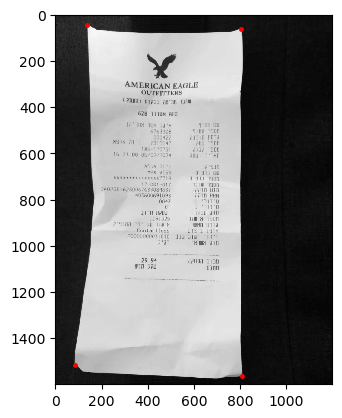

In [97]:
corners = corner_peaks(harris_response, min_distance=35, threshold_rel=0.03)
selected_corners = corners[(corners[:, 0] < 150) | (corners[:, 0] > 1500)]
fig, ax = plt.subplots()
ax.imshow(img, interpolation='nearest', cmap=plt.cm.gray)
ax.plot(selected_corners[:, 1],selected_corners[:, 0], '.r', markersize=5)
plt.show()

___document alignment___

We will derive from the original image a rectangle whose borders will be determined according to the points we found in the Hough transform function.


(We will take an average of each coordinate from the two coordinates of the beginning and end of a line)

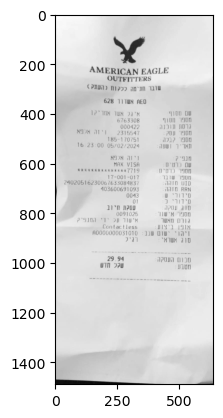

In [98]:
x0 = int((x0_first_line + x1_first_line)/ 2)
x1 = int((x0_second_line + x1_second_line)/ 2)
y0 = int((y0_first_line + y1_first_line)/ 2)
y1 = int((y0_second_line + y1_second_line)/ 2)
cropped_image = img[y0:y1, x0:x1]

plt.imshow(cropped_image, cmap=plt.cm.gray)
plt.show()

___2. segmentation___
-----

using otsu threshold algorithm to find the best threshold of the histogram of the image.

Separates the image into two colors: if smaller/equal than threshold - black. otherwise - white

In [99]:
import os
from skimage import data, segmentation, color
from skimage.filters import gaussian, threshold_otsu

In [100]:
nbins = 256
t = threshold_otsu(cropped_image, nbins=nbins)
img_th = cropped_image.copy()
img_th[img_th <= t] = 0
img_th[img_th > t] = 255

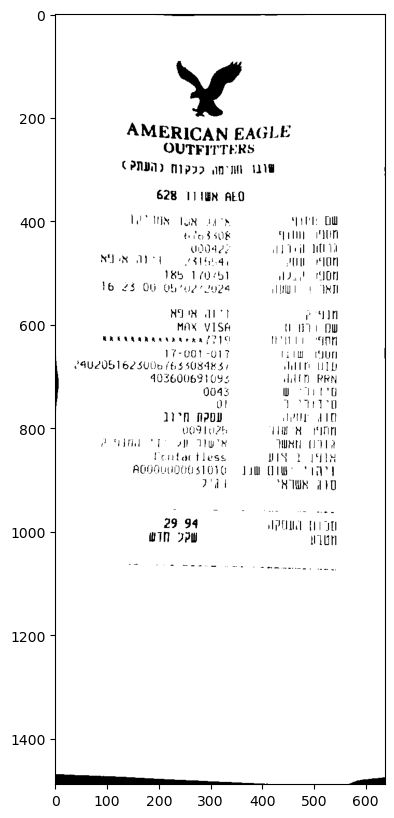

In [101]:
plt.subplots(figsize=(15, 10))
plt.imshow(img_th, cmap=plt.cm.gray)

___3. correlation___
--------------------

Using correlation analysis to determine whether the image matches the one on the ID.

------------------------------------------------------------
takes an input image and pads it with zeros around its borders. 

purpose: adjust the size of the image while maintaining its original content to handle border effects result of the convolutional operations below.

In [102]:
def zero_pad(image, pad_height, pad_width):
    H, W = image.shape
    out = np.zeros((H+2*pad_height, W+2*pad_width))
    out[pad_height:pad_height+H, pad_width:pad_width+W] = image
    return out

Doing fast convolution:

First, it adds zeros around the edges of the image using zero_pad(). Then, it goes through each pixel in the image, multiplying nearby pixels with the kernel. After that, it adds up all these products to get a new pixel value. Finally, it gives back the updated image.

In [103]:

def conv_fast(image, kernel):
    Hi, Wi = image.shape
    Hk, Wk = kernel.shape
    out = np.zeros((Hi, Wi))
    image_pad = zero_pad(image, int(Hk/2), int(Wk/2))
    for hi in range(Hi):
        for wi in range(Wi):
            out[hi, wi] = np.sum(image_pad[hi:hi+Hk, wi:wi+Wk]*kernel)
    return out


verify if the smaller image exists within the larger one using conv_fast().

In [104]:
def zero_mean_cross_correlation(f, g):
    Hf, Wf = f.shape
    out = np.zeros((Hf, Wf))
    g = g - np.mean(g)
    out = conv_fast(f, g)
    return out


loading two images. the id picture and face picture. using the zero_mean_cross_correlation() to determine whether the facial image is present in the ID card. And if so, we will mark the location of the face on the ID card with an X.

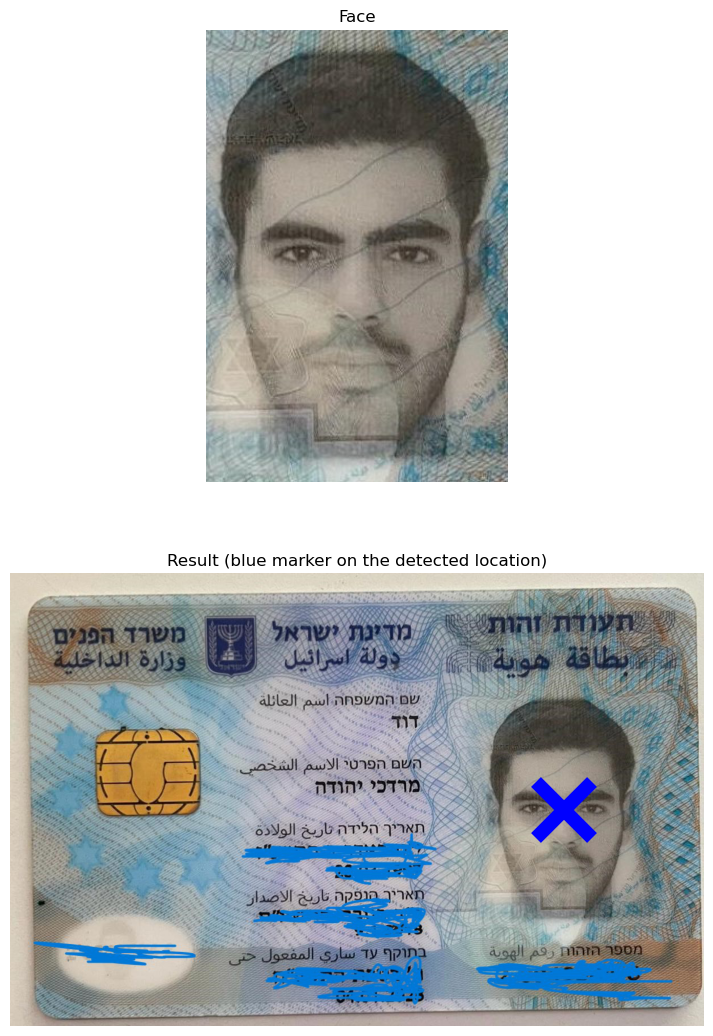

In [105]:
img_id = io.imread('id.jpg')
img_id_grey = io.imread('id.jpg', as_gray=True)
face_img = io.imread('face.jpg')
face_img_grey = io.imread('face.jpg', as_gray=True)

# Perform cross-correlation between the ID image and the face image
out = zero_mean_cross_correlation(img_grey, face_img_grey)

# Find the location with maximum similarity
y,x = (np.unravel_index(out.argmax(), out.shape))

# Display product template
plt.figure(figsize=(30,20))
plt.subplot(3, 1, 1)
plt.imshow(face_img)
plt.title('Face')
plt.axis('off')


# Display image
plt.subplot(3, 1, 2)
plt.imshow(img_id)
plt.title('Result (blue marker on the detected location)')
plt.axis('off')

# Draw marker at detcted location
plt.plot(x, y, 'bx', ms=40, mew=10)
plt.show()


___try to compare to face that is not identical to those in the ID card and present the result if there is a X marker in right place on ID card as before or not___


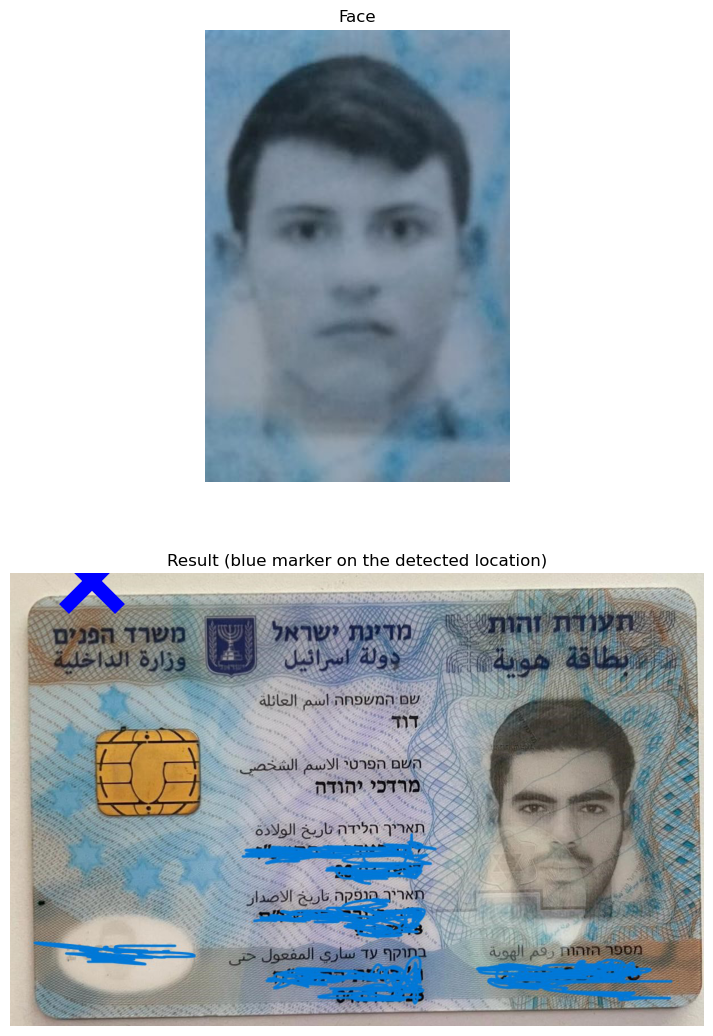

In [106]:
face_another_img = io.imread('other_face.jpg')
face_another_img_grey = io.imread('other_face.jpg', as_gray=True)

# Perform cross-correlation between the ID image and the face image
out = zero_mean_cross_correlation(img_grey, face_another_img_grey)

# Find the location with maximum similarity
y,x = (np.unravel_index(out.argmax(), out.shape))

# Display product template
plt.figure(figsize=(30,20))
plt.subplot(3, 1, 1)
plt.imshow(face_another_img)
plt.title('Face')
plt.axis('off')


# Display image
plt.subplot(3, 1, 2)
plt.imshow(img_id)
plt.title('Result (blue marker on the detected location)')
plt.axis('off')

# Draw marker at detcted location
plt.plot(x, y, 'bx', ms=40, mew=10)
plt.show()


__4. Panorama stitching__
----------------------------------------

showing the 2 ticket images

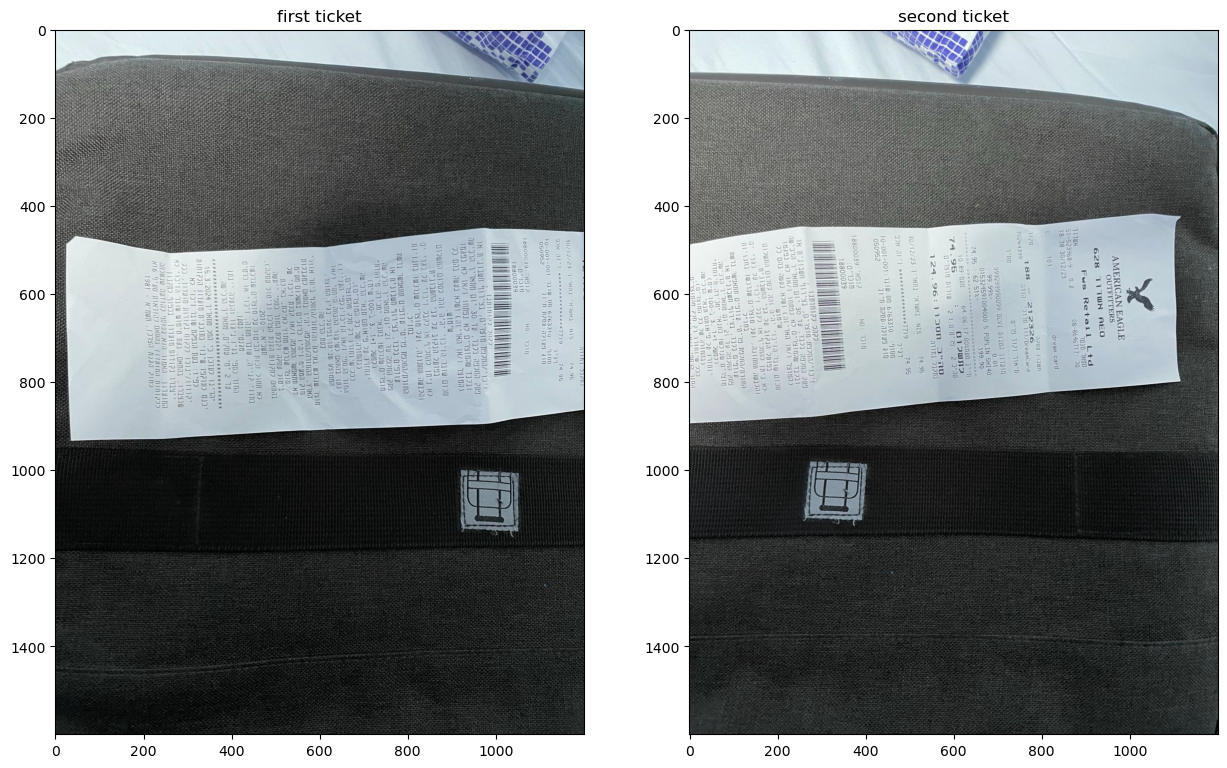

In [112]:
image1 = cv2.imread('first_ticket.jpg')
image2 = cv2.imread('second_ticket.jpg')

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 15))
ax[0].imshow(image1)
ax[0].set_title('first ticket')
ax[1].imshow(image2)
ax[1].set_title('second ticket')
plt.show()

creating object of cv2.Stitcher_create and use sttich function to stitch two ticket images.


Then, inverts and displays the one panorama image.

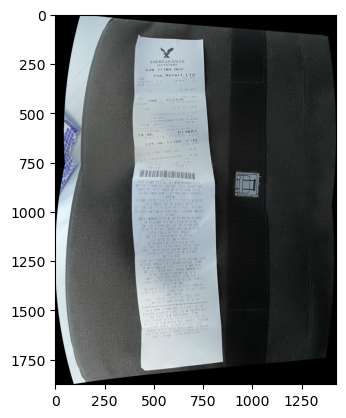

In [113]:
# creating and using Stitcher object in cv2 to do panorama stitching
stitcher = cv2.Stitcher_create()

status, stitched_image = stitcher.stitch([image1, image2])

if status == cv2.Stitcher_OK:
    image_to_present = cv2.rotate(stitched_image, cv2.ROTATE_90_COUNTERCLOCKWISE)
    plt.imshow(image_to_present)
else:
    print("Error during stitching")
